<a href="https://colab.research.google.com/github/siva8696/KNN-on-Cancer-Diagnosis/blob/master/KNN_Cancer_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Personalized cancer diagnosis

**Description :**

Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/

Data: Memorial Sloan Kettering Cancer Center (MSKCC)

Download training_variants.zip and training_text.zip from Kaggle.

Context:
Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462

Problem statement :
Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

**Real-world/Business objectives and constraints.**

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

**ML Problem formulation :**

**Data Overview**

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

**Objective and Constraints :**

Objective: Predict the probability of each data-point belonging to each of the nine classes.

Constraints:

* Interpretability * Class probabilities are needed. * Penalize the errors in class probabilites => Metric is Log-loss. * No Latency constraints.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


**Reading Data**

**Reading Training Variants and Text data :**

In [3]:
import os
cwd = os.getcwd()
#print(cwd)
files = os.listdir(cwd)
#print(files)
data_var= pd.read_csv("sample_data/Case_Study1/training_variants")
#data_text=pd.read_csv("Case_Study1/training_text")
print("The Shape of the varaiants data is :",data_var.shape)
print("The total number of data points in variants data is",data_var.shape[0])
print("The total number of features in variants data is",data_var.shape[1])
print("The features are :",data_var.columns.values)
print("*"*50)
print(data_var.head())

The Shape of the varaiants data is : (3321, 4)
The total number of data points in variants data is 3321
The total number of features in variants data is 4
The features are : ['ID' 'Gene' 'Variation' 'Class']
**************************************************
   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4


In [4]:
data_text=pd.read_csv("sample_data/Case_Study1/training_text" , sep="\|\|", names=["ID","Text"], skiprows=1)
print("The Shape of the test data is :",data_text.shape)
print("The total number of data points in text data is",data_text.shape[0])
print("The total number of features in text data is",data_text.shape[1])
print("The features are :",data_text.columns.values)
print("*"*50)
print(data_text.head())

The Shape of the test data is : (3321, 2)
The total number of data points in text data is 3321
The total number of features in text data is 2
The features are : ['ID' 'Text']
**************************************************
   ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...


**Preprocessing on  Text :**

In [5]:
import nltk
stop_words1 = nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
print(stop_words)

{'do', 'same', 'yourself', 'don', 'y', 'hasn', "won't", 'once', 'weren', "it's", 'up', 'out', 'now', 'doing', "aren't", 'then', 'of', 'while', 'such', 'only', 'your', 'too', 'that', "wasn't", 'd', "you're", 'on', 'his', 'when', 'between', 'own', 'didn', 'no', "mightn't", 'yourselves', 'some', 'ain', 'are', "wouldn't", 'so', 'can', 'ma', 'have', 'themselves', "couldn't", 'hers', 'their', 'had', "that'll", 'to', 'over', 'wasn', 'is', "she's", 'through', 've', 'our', 'those', "should've", 'won', 'until', 'am', 'ours', 'under', 'they', "you'd", 'its', 'itself', 'should', 'm', 'isn', 'how', 'who', 'ourselves', 're', 'by', 'other', 'an', 'from', 'below', "don't", "hadn't", 'been', 'because', 't', 'just', 'couldn', 'mightn', 'he', 'being', 'in', 'down', 'shouldn', "needn't", 'you', 'my', 'not', 'we', 'but', 'having', 's', 'why', 'wouldn', 'o', "doesn't", 'most', 'during', "haven't", "you'll", 'did', 'hadn', 'than', 'what', 'i', 'where', 'if', 'was', 'few', 'against', 'haven', 'myself', 'him',

In [0]:
def nlp_preprocessing(text,index, column):
  if type(text) is not int:
    #Intiallizing the empty string
    string = ""
    #Removing the specail character and replace it with space
    text = re.sub('[^a-zA-Z0-9\n]',' ',text)
    #Removing the multiple spaces and replace it with single space
    text = re.sub('\s+',' ',text)
    #Converting the text into lower_case
    text = text.lower()
    #Removing the stop words from text and saving back into String
    
    for word in text.split():
      if not word in stop_words:
        string += word + " "
    data_text[column][index]=string
        

In [8]:
#Checking the starting time
start_time = time.clock()
#Using iterrows we are iterating the data frame with index 
for index, row in data_text.iterrows():
  if type(row['Text']) is str:
    nlp_preprocessing(row['Text'],index,'Text')
  else:
    print("There is no string at Index:", index)
print("Time taking to process the text data is :",time.clock()-start_time,"Seconds")

There is no string at Index: 1109
There is no string at Index: 1277
There is no string at Index: 1407
There is no string at Index: 1639
There is no string at Index: 2755
Time taking to process the text data is : 29.464112999999998 Seconds


In [9]:
#Merging the both Gene variations and Text data using ID
final_data = pd.merge(data_var,data_text, on = 'ID', how='left')
print(final_data.head())

   ID    Gene  ... Class                                               Text
0   0  FAM58A  ...     1  cyclin dependent kinases cdks regulate variety...
1   1     CBL  ...     2  abstract background non small cell lung cancer...
2   2     CBL  ...     2  abstract background non small cell lung cancer...
3   3     CBL  ...     3  recent evidence demonstrated acquired uniparen...
4   4     CBL  ...     4  oncogenic mutations monomeric casitas b lineag...

[5 rows x 5 columns]


In [10]:
final_data[final_data.isnull().values.any(axis=1)]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [11]:
final_data['Text'].isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
3316    False
3317    False
3318    False
3319    False
3320    False
Name: Text, Length: 3321, dtype: bool

In [0]:
final_data.loc[final_data['Text'].isnull(),'Text'] = final_data['Gene'] +' ' +final_data['Variation']

Splitting the data into Train and CV and Test :

In [0]:
y_value = final_data['Class'].values
#Dividing the data into Train and Test and CV and Stratify make the class label in same distribution
X_train, X_test, y_train, y_test = train_test_split(final_data, y_value, stratify=y_value, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train ,test_size=0.2, random_state=42)

In [14]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)
print("Number of data points in cv data :",X_cv.shape)

Number of data points in train data : (2124, 5)
Number of data points in test data : (665, 5)
Number of data points in cv data : (532, 5)


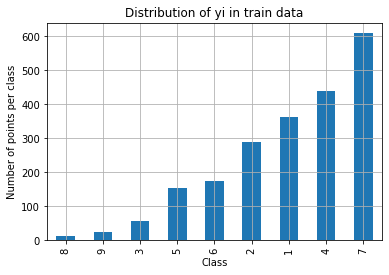

**************************************************


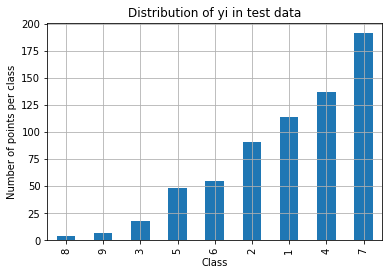

**************************************************


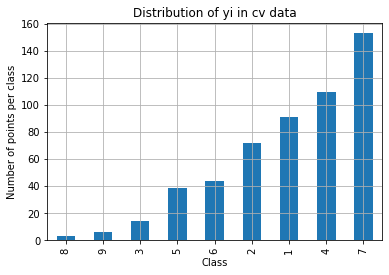

In [15]:
train_class_distribution=X_train['Class'].value_counts().sort_values()
#Plotting the distribution of yi in train data
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of points per class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()


print('*'*50)

test_class_distribution=X_test['Class'].value_counts().sort_values()
#Plotting the distribution of yi in test data
my_colors='rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of points per class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

print('*'*50)

cv_class_distribution=X_cv['Class'].value_counts().sort_values()
#Plotting the distribution of yi in test data
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of points per class')
plt.title('Distribution of yi in cv data')
plt.grid()
plt.show()

**Confusion Matrix, Precision, Re-call :**

In [0]:
def plot_confusion_matrix(y_test, y_pred):
  #Confusion matrix
  A = confusion_matrix(y_test,y_pred)
  #Precision matrix
  B = (((A.T)/(A.sum(axis=1))).T)
  #Recall matrix
  C = (A/A.sum(axis=0))

  labels = [1,2,3,4,5,6,7,8,9]
  #Plot the consuion matrix
  print("-"*20,"Confusion matrix","-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(A,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
  plt.xlabel("predicted Class")
  plt.ylabel("Actual Class")
  plt.show()

  #Plot the precision matrix
  print("-"*20,"Precision matrix (Column Sum = 1)","-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(C,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
  plt.xlabel("predicted Class")
  plt.ylabel("Actual Class")
  plt.show()

  #Plot the recall matrix
  print("-"*20,"Recall matrix (Row Sum = 1)","-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(B,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
  plt.xlabel("predicted Class")
  plt.ylabel("Actual Class")
  plt.show()



**Univariate analysis in Gene feature:**

In [17]:
unique_gene = X_train['Gene'].value_counts()
print("Number of unique Gene features are:",unique_gene[0])
print(unique_gene.head(10))

Number of unique Gene features are: 154
BRCA1     154
TP53      104
EGFR       89
PTEN       88
BRCA2      83
KIT        63
BRAF       60
ALK        43
PDGFRA     41
ERBB2      41
Name: Gene, dtype: int64


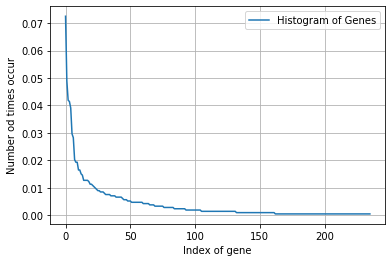

In [18]:
#print(unique_gene.values)
#print(sum(unique_gene.values))
s = sum(unique_gene.values)
h = unique_gene.values/s
plt.plot(h,label="Histogram of Genes")
plt.xlabel("Index of gene")
plt.ylabel("Number od times occur")
plt.legend()
plt.grid()
plt.show()

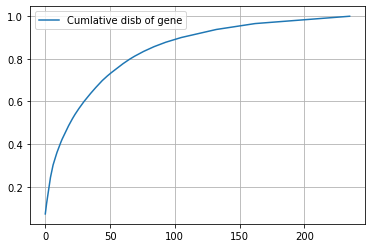

In [19]:
t = np.cumsum(h)
plt.plot(t,label="Cumlative disb of gene")
plt.legend()
plt.grid()
plt.show()

In [27]:
#Featurization for Gene feature using Tfidf Vectorizer
gene_vectorizer = TfidfVectorizer(stop_words='english')
train_gene_feature_tfidf = gene_vectorizer.fit_transform(X_train['Gene'])
cv_gene_feature_tfidf = gene_vectorizer.transform(X_cv['Gene'])
test_gene_feature_tfidf = gene_vectorizer.transform(X_test['Gene'])
print(train_gene_feature_tfidf.shape)
print(cv_gene_feature_tfidf.shape)
print(test_gene_feature_tfidf.shape)

(2124, 236)
(532, 236)
(665, 236)


For the K value  5 the logg loss is : 1.2897951111711372
For the K value  11 the logg loss is : 1.267549643309653
For the K value  21 the logg loss is : 1.2780293311888733
For the K value  31 the logg loss is : 1.316216347483789
For the K value  41 the logg loss is : 1.3444935671128593
For the K value  50 the logg loss is : 1.3609847745168424


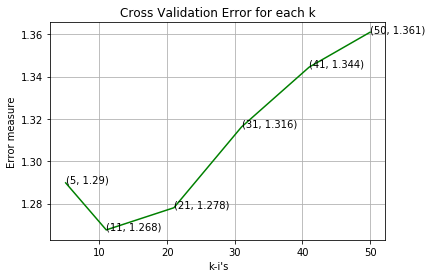

For values of best K =  11 The train log loss is: 1.1701666459259183
For values of best K =  11 The cross validation log loss is: 1.267549643309653
For values of best K =  11 The test log loss is: 1.3339494334028685


In [28]:
k = [5,11,21,31,41,50]
cv_log_error = []
for i in k:
  clf=KNeighborsClassifier(n_neighbors=i)
  clf.fit(train_gene_feature_tfidf,y_train)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_gene_feature_tfidf,y_train)
  predicted_y=sig_clf.predict_proba(cv_gene_feature_tfidf)
  cv_log_error.append(log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))
  print("For the K value ",i,"the logg loss is :",log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))


fig, ax = plt.subplots()
ax.plot(k, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((k[i],np.round(txt,3)), (k[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each k")
plt.xlabel("k-i's")
plt.ylabel("Error measure")
plt.show()


best_k_gene = np.argmin(cv_log_error)
clf = KNeighborsClassifier(n_neighbors=k[best_k_gene])
clf.fit(train_gene_feature_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_tfidf, y_train)

predict_y_gene = sig_clf.predict_proba(train_gene_feature_tfidf)
print('For values of best K = ', k[best_k_gene], "The train log loss is:",log_loss(y_train, predict_y_gene, labels=clf.classes_, eps=1e-15))
predict_y1_gene = sig_clf.predict_proba(cv_gene_feature_tfidf)
print('For values of best K = ', k[best_k_gene], "The cross validation log loss is:",log_loss(y_cv, predict_y1_gene, labels=clf.classes_, eps=1e-15))
predict_y2_gene = sig_clf.predict_proba(test_gene_feature_tfidf)
print('For values of best K = ', k[best_k_gene], "The test log loss is:",log_loss(y_test, predict_y2_gene, labels=clf.classes_, eps=1e-15))


In [29]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_gene.shape[0], " genes in train dataset?")

test_coverage=X_test[X_test['Gene'].isin(list(set(X_train['Gene'])))].shape[0]
cv_coverage=X_cv[X_cv['Gene'].isin(list(set(X_train['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_cv.shape[0],":" ,(cv_coverage/X_cv.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  236  genes in train dataset?
Ans
1. In test data 642 out of 665 : 96.54135338345866
2. In cross validation data 523 out of  532 : 98.30827067669173


As per the above analysis the Gene feature will be helpful for us to creating the model. Along with that we can see almost more than 96 percentage of test gene features are available in train gene.

**Univariate analysis on Variant feature :**

In [30]:
unique_var = X_train['Variation'].value_counts()
print("Number of unique Gene features are:",unique_var[0])
print(unique_var.head(10))

Number of unique Gene features are: 66
Truncating Mutations    66
Amplification           47
Deletion                42
Fusions                 23
Overexpression           4
T58I                     3
M1R                      2
K117N                    2
C618R                    2
E17K                     2
Name: Variation, dtype: int64


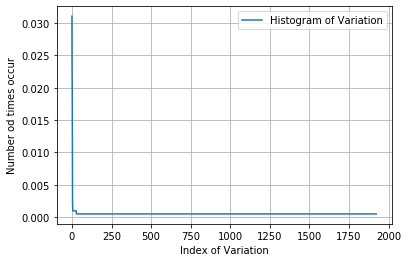

In [31]:
#print(unique_gene.values)
#print(sum(unique_gene.values))
s = sum(unique_var.values)
h = unique_var.values/s
plt.plot(h,label="Histogram of Variation")
plt.xlabel("Index of Variation")
plt.ylabel("Number od times occur")
plt.legend()
plt.grid()
plt.show()

In [32]:
#Tfidf Vectorizer for Variation feature
tfidf = TfidfVectorizer(stop_words="english")
train_var_feature_tfidf = tfidf.fit_transform(X_train['Variation'])
cv_var_feature_tfidf = tfidf.transform(X_cv['Variation'])
test_var_feature_tfidf = tfidf.transform(X_test['Variation'])
print(train_var_feature_tfidf.shape)
print(cv_var_feature_tfidf.shape)
print(test_var_feature_tfidf.shape)

(2124, 1950)
(532, 1950)
(665, 1950)


For the K value  5 the logg loss is : 1.79880499926322
For the K value  11 the logg loss is : 1.7666808792450264
For the K value  21 the logg loss is : 1.767840618318479
For the K value  31 the logg loss is : 1.834761124527696
For the K value  41 the logg loss is : 1.7695839273456124
For the K value  50 the logg loss is : 1.782775427380947


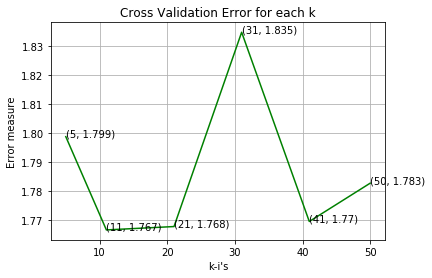

For values of best K =  11 The train log loss is: 1.7510988328122055
For values of best K =  11 The cross validation log loss is: 1.7666808792450264
For values of best K =  11 The test log loss is: 1.7717119809711275


In [33]:
k = [5,11,21,31,41,50]
cv_log_error = []
for i in k:
  clf=KNeighborsClassifier(n_neighbors=i)
  clf.fit(train_var_feature_tfidf,y_train)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_var_feature_tfidf,y_train)
  predicted_y=sig_clf.predict_proba(cv_var_feature_tfidf)
  cv_log_error.append(log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))
  print("For the K value ",i,"the logg loss is :",log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))


fig, ax = plt.subplots()
ax.plot(k, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((k[i],np.round(txt,3)), (k[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each k")
plt.xlabel("k-i's")
plt.ylabel("Error measure")
plt.show()


best_k_var = np.argmin(cv_log_error)
clf = KNeighborsClassifier(n_neighbors=k[best_k_var])
clf.fit(train_var_feature_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_var_feature_tfidf, y_train)

predict_y_var = sig_clf.predict_proba(train_var_feature_tfidf)
print('For values of best K = ', k[best_k_var], "The train log loss is:",log_loss(y_train, predict_y_var, labels=clf.classes_, eps=1e-15))
predict_y1_var = sig_clf.predict_proba(cv_var_feature_tfidf)
print('For values of best K = ', k[best_k_var], "The cross validation log loss is:",log_loss(y_cv, predict_y1_var, labels=clf.classes_, eps=1e-15))
predict_y2_var = sig_clf.predict_proba(test_var_feature_tfidf)
print('For values of best K = ', k[best_k_var], "The test log loss is:",log_loss(y_test, predict_y2_var, labels=clf.classes_, eps=1e-15))

In [34]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_var.shape[0], " variation in train dataset?")

test_coverage=X_test[X_test['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
cv_coverage=X_cv[X_cv['Variation'].isin(list(set(X_train['Variation'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_cv.shape[0],":" ,(cv_coverage/X_cv.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  1923  variation in train dataset?
Ans
1. In test data 67 out of 665 : 10.075187969924812
2. In cross validation data 53 out of  532 : 9.962406015037594


As per the above analysis the Variation feature will be not helpful for us to creating the model. Along with that we can see almost around 10 percentage of test Variation features are available in train Variation.

**Univariate analysis on Text feature :**

In [46]:
#Tfidf Vectorizer for Text feature
tfidf = TfidfVectorizer(stop_words="english",min_df=5,max_features=15000)
train_text_feature_tfidf = tfidf.fit_transform(X_train['Text'])
cv_text_feature_tfidf = tfidf.transform(X_cv['Text'])
test_text_feature_tfidf = tfidf.transform(X_test['Text'])
print(train_text_feature_tfidf.shape)
print(cv_text_feature_tfidf.shape)
print(test_text_feature_tfidf.shape)

(2124, 15000)
(532, 15000)
(665, 15000)


In [47]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
train_text_feature_tfidf = sc.fit_transform(train_text_feature_tfidf)
cv_text_feature_tfidf = sc.transform(cv_text_feature_tfidf)
test_text_feature_tfidf = sc.transform(test_text_feature_tfidf)
print(train_text_feature_tfidf.shape)
print(cv_text_feature_tfidf.shape)
print(test_text_feature_tfidf.shape)

(2124, 15000)
(532, 15000)
(665, 15000)


For the K value  5 the logg loss is : 1.253825185443886
For the K value  11 the logg loss is : 1.3170689768487989
For the K value  21 the logg loss is : 1.3489876021260876
For the K value  31 the logg loss is : 1.3598759931333357
For the K value  41 the logg loss is : 1.347056243849242
For the K value  50 the logg loss is : 1.3532531167314943


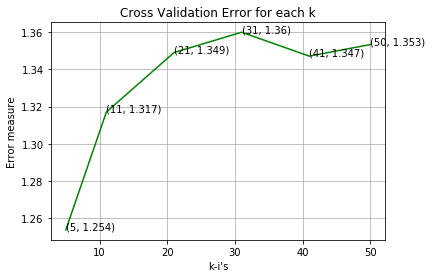

For values of best K =  5 The train log loss is: 1.0010090484247125
For values of best K =  5 The cross validation log loss is: 1.253825185443886
For values of best K =  5 The test log loss is: 1.3551732425230456


In [48]:
k = [5,11,21,31,41,50]
cv_log_error = []
for i in k:
  clf=KNeighborsClassifier(n_neighbors=i)
  clf.fit(train_text_feature_tfidf,y_train)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_text_feature_tfidf,y_train)
  predicted_y=sig_clf.predict_proba(cv_text_feature_tfidf)
  cv_log_error.append(log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))
  print("For the K value ",i,"the logg loss is :",log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))


fig, ax = plt.subplots()
ax.plot(k, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((k[i],np.round(txt,3)), (k[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each k")
plt.xlabel("k-i's")
plt.ylabel("Error measure")
plt.show()


best_k_text = np.argmin(cv_log_error)
clf = KNeighborsClassifier(n_neighbors=k[best_k_text])
clf.fit(train_text_feature_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_tfidf, y_train)

predict_y_text = sig_clf.predict_proba(train_text_feature_tfidf)
print('For values of best K = ', k[best_k_text], "The train log loss is:",log_loss(y_train, predict_y_text, labels=clf.classes_, eps=1e-15))
predict_y1_text = sig_clf.predict_proba(cv_text_feature_tfidf)
print('For values of best K = ', k[best_k_text], "The cross validation log loss is:",log_loss(y_cv, predict_y1_text, labels=clf.classes_, eps=1e-15))
predict_y2_text = sig_clf.predict_proba(test_text_feature_tfidf)
print('For values of best K = ', k[best_k_text], "The test log loss is:",log_loss(y_test, predict_y2_text, labels=clf.classes_, eps=1e-15))

In [0]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [0]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [51]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_tfidf = hstack((train_gene_feature_tfidf,train_var_feature_tfidf))
cv_gene_var_tfidf = hstack((cv_gene_feature_tfidf,cv_var_feature_tfidf))
test_gene_var_tfidf = hstack((test_gene_feature_tfidf,test_var_feature_tfidf))
print("Shape of Gene feature in Train data is :",train_gene_feature_tfidf.shape[0])
print("Shape of Variation feature in Train data is :",train_var_feature_tfidf.shape[0])
print("Shape of Gene and Variation feature in Train data is :",train_gene_var_tfidf.shape[0])

train_x_tfidfCoding = hstack((train_gene_var_tfidf, train_text_feature_tfidf)).tocsr()
train_y = np.array(list(X_train['Class']))

test_x_tfidfCoding = hstack((test_gene_var_tfidf, test_text_feature_tfidf)).tocsr()
test_y = np.array(list(X_test['Class']))

cv_x_tfidfCoding = hstack((cv_gene_var_tfidf, cv_text_feature_tfidf)).tocsr()
cv_y = np.array(list(X_cv['Class']))

Shape of Gene feature in Train data is : 2124
Shape of Variation feature in Train data is : 2124
Shape of Gene and Variation feature in Train data is : 2124


In [52]:
print("Tfidf encoding features :")
print("(number of data points * number of features) in train data = ", train_x_tfidfCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_tfidfCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_tfidfCoding.shape)

Tfidf encoding features :
(number of data points * number of features) in train data =  (2124, 17186)
(number of data points * number of features) in test data =  (665, 17186)
(number of data points * number of features) in cross validation data = (532, 17186)


<h2> Build KNN Model :

For the K value  5 the logg loss is : 1.2529227353850132
For the K value  11 the logg loss is : 1.316467134268393
For the K value  21 the logg loss is : 1.3489876021260876
For the K value  31 the logg loss is : 1.359896352195047
For the K value  41 the logg loss is : 1.3472007639499524
For the K value  50 the logg loss is : 1.3528950717164705
For the K value  99 the logg loss is : 1.3385318405394608


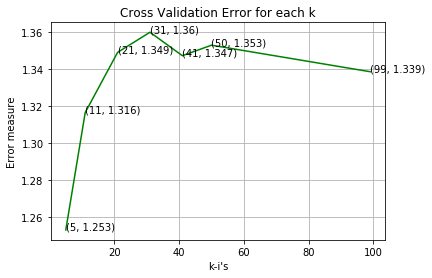

For values of best K =  5 The train log loss is: 0.9937523548980903
For values of best K =  5 The cross validation log loss is: 1.2529227353850132
For values of best K =  5 The test log loss is: 1.354902415426144


In [53]:
k = [5,11,21,31,41,50,99]
cv_log_error = []
for i in k:
  clf=KNeighborsClassifier(n_neighbors=i)
  clf.fit(train_x_tfidfCoding,y_train)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_x_tfidfCoding,y_train)
  predicted_y=sig_clf.predict_proba(cv_x_tfidfCoding)
  cv_log_error.append(log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))
  print("For the K value ",i,"the logg loss is :",log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))


fig, ax = plt.subplots()
ax.plot(k, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((k[i],np.round(txt,3)), (k[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each k")
plt.xlabel("k-i's")
plt.ylabel("Error measure")
plt.show()


best_k_model = np.argmin(cv_log_error)
clf = KNeighborsClassifier(n_neighbors=k[best_k_model])
clf.fit(train_x_tfidfCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidfCoding, y_train)

predict_y_model = sig_clf.predict_proba(train_x_tfidfCoding)
print('For values of best K = ', k[best_k_model], "The train log loss is:",log_loss(y_train, predict_y_model, labels=clf.classes_, eps=1e-15))
predict_y1_model = sig_clf.predict_proba(cv_x_tfidfCoding)
print('For values of best K = ', k[best_k_model], "The cross validation log loss is:",log_loss(y_cv, predict_y1_model, labels=clf.classes_, eps=1e-15))
predict_y2_model = sig_clf.predict_proba(test_x_tfidfCoding)
print('For values of best K = ', k[best_k_model], "The test log loss is:",log_loss(y_test, predict_y2_model, labels=clf.classes_, eps=1e-15))

**Testing model with best hyper-parameter :**

Log loss : 1.354902415426144
Number of mis-classified points : 0.4631578947368421
-------------------- Confusion matrix --------------------


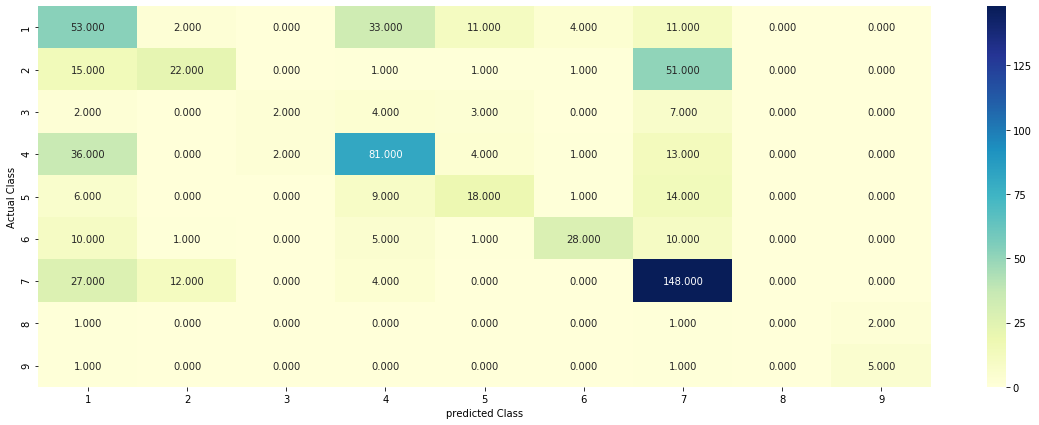

-------------------- Precision matrix (Column Sum = 1) --------------------


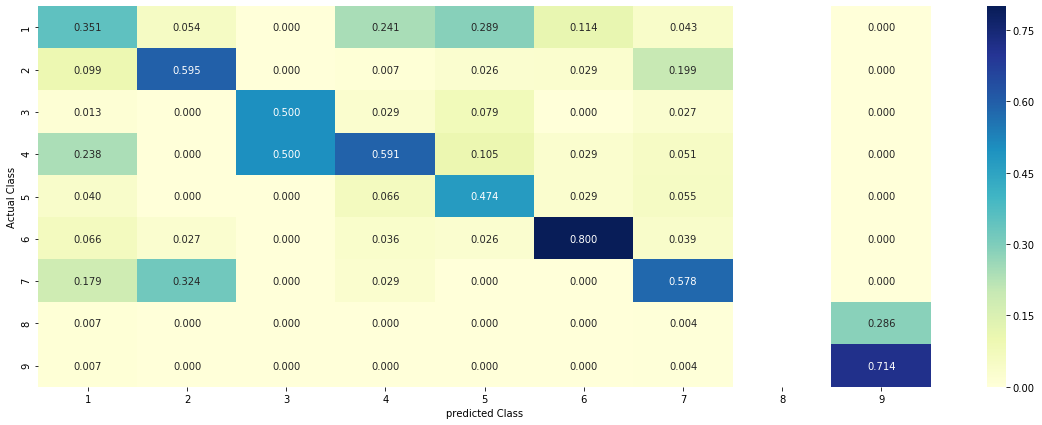

-------------------- Recall matrix (Row Sum = 1) --------------------


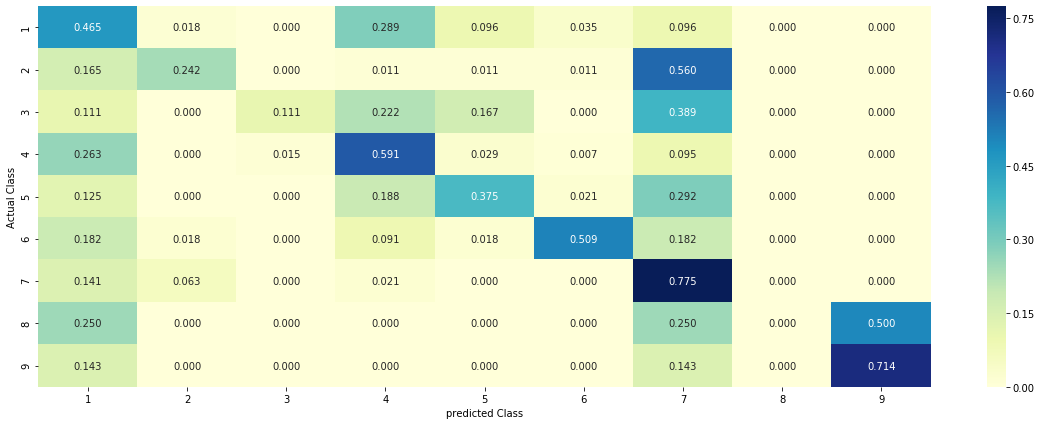

In [54]:
clf = KNeighborsClassifier(n_neighbors=k[best_k_model])
predict_and_plot_confusion_matrix(train_x_tfidfCoding, y_train, test_x_tfidfCoding, y_test, clf)

Sample query point for correct class label:

In [75]:
clf = KNeighborsClassifier(n_neighbors=k[best_k_model])
clf.fit(train_x_tfidfCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidfCoding, y_train)

test_point_index = 10
predicted_cls = sig_clf.predict(test_x_tfidfCoding[test_point_index].reshape(1,-1))
#print(predicted_cls)
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", y_test[test_point_index])
neighbors = clf.kneighbors(test_x_tfidfCoding[test_point_index].reshape(1, -1), k[best_k_model])
#print(neighbors)
print("The ",k[best_k_model]," nearest neighbours of the test points belongs to classes",y_train[neighbors[1][0]])
print("Fequency of nearest points :",Counter(y_train[neighbors[1][0]]))


Predicted Class : 1
Actual Class : 1
The  5  nearest neighbours of the test points belongs to classes [1 7 4 1 1]
Fequency of nearest points : Counter({1: 3, 7: 1, 4: 1})


Sample query point for Incorrect class label:

In [76]:
test_point_index = 99
predicted_cls = sig_clf.predict(test_x_tfidfCoding[test_point_index].reshape(1,-1))
#print(predicted_cls)
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", y_test[test_point_index])
neighbors = clf.kneighbors(test_x_tfidfCoding[test_point_index].reshape(1, -1), k[best_k_model])
#print(neighbors)
print("The ",k[best_k_model]," nearest neighbours of the test points belongs to classes",y_train[neighbors[1][0]])
print("Fequency of nearest points :",Counter(y_train[neighbors[1][0]]))


Predicted Class : 7
Actual Class : 5
The  5  nearest neighbours of the test points belongs to classes [7 2 2 1 7]
Fequency of nearest points : Counter({7: 2, 2: 2, 1: 1})


<h3> Results: </h3>

In [77]:
from prettytable import PrettyTable

x=PrettyTable()
x.field_names = ["Feature_Name","Best Hyperparameter","Train Log_Loss","CV Log_Loss","Test Log_Loss"]
x.add_row(["Gene", k[best_k_gene],log_loss(y_train, predict_y_gene, labels=clf.classes_, eps=1e-15), log_loss(y_cv, predict_y1_gene, labels=clf.classes_, eps=1e-15),log_loss(y_test, predict_y2_gene, labels=clf.classes_, eps=1e-15)])
x.add_row(["Variation", k[best_k_var],log_loss(y_train, predict_y_var, labels=clf.classes_, eps=1e-15),log_loss(y_cv, predict_y1_var, labels=clf.classes_, eps=1e-15),log_loss(y_test, predict_y2_var, labels=clf.classes_, eps=1e-15)])
x.add_row(["Text", k[best_k_text],log_loss(y_train, predict_y_text, labels=clf.classes_, eps=1e-15),log_loss(y_cv, predict_y1_text, labels=clf.classes_, eps=1e-15),log_loss(y_test, predict_y2_text, labels=clf.classes_, eps=1e-15)])
x.add_row(["Gene+Variation+Text", k[best_k_model],log_loss(y_train, predict_y_model, labels=clf.classes_, eps=1e-15),log_loss(y_cv, predict_y1_model, labels=clf.classes_, eps=1e-15),log_loss(y_test, predict_y2_model, labels=clf.classes_, eps=1e-15)])
print(x)

+---------------------+---------------------+--------------------+--------------------+--------------------+
|     Feature_Name    | Best Hyperparameter |   Train Log_Loss   |    CV Log_Loss     |   Test Log_Loss    |
+---------------------+---------------------+--------------------+--------------------+--------------------+
|         Gene        |          11         | 1.1701666459259183 | 1.267549643309653  | 1.3339494334028685 |
|      Variation      |          11         | 1.7510988328122055 | 1.7666808792450264 | 1.7717119809711275 |
|         Text        |          5          | 1.0010090484247125 | 1.253825185443886  | 1.3551732425230456 |
| Gene+Variation+Text |          5          | 0.9937523548980903 | 1.2529227353850132 | 1.354902415426144  |
+---------------------+---------------------+--------------------+--------------------+--------------------+


Using KNN on Variation and Gene and Text feature we got the log-loss value as about 1.35.